In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model
from keras.losses import mean_absolute_error
import tensorflow as tf
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.utils import plot_model

from LRF import LRFinder
from SGDR import SGDRScheduler

Using TensorFlow backend.


In [2]:
train_path = 'X:/Flipkart GRID - Object Localization (Medium Complexity Round)/augument_data/training_images'
npy_img_dir = 'X:/Flipkart GRID - Object Localization (Medium Complexity Round)\\augument_data\\training_images_batches'
architecture_plot_save_dir = 'X:/Flipkart GRID - Object Localization (Medium Complexity Round)/'

img_width, img_height = 299., 299.
rx = 2.1404
ry = 1.61

In [3]:
##### img_width, img_height = 640, 480
base_dir = 'X:/Flipkart GRID - Object Localization (Medium Complexity Round)/'
# train_data_dir = "X:/train-scene classification/data/train/"
# validation_data_dir = "X:/train-scene classification/data/valid/"
# test_data_dir = "X:/train-scene classification/data/test/"
epochs = 1000
# Save the model according to the conditions  
chkpt_dir = "X:/Flipkart GRID - Object Localization (Medium Complexity Round)/chkpts/resnet50_lrf_chkpt.h5" # Change for every new training session 

In [4]:
base_model = load_model(os.path.join(base_dir,'base_models', 'resnet50.h5')) # use this to load from base_models dir
# base_model = load_model(os.path.join(base_dir, 'notebooks', 'inceptionresnetv2_93tr83val_(6-2-19_00.09).h5')) # use this to load from notebooks dir

C:\Users\praty\Anaconda3\envs\dlenv\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [5]:
# for layer in base_model.layers[:-3]:
#     layer.trainable = False
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 640, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 486, 646, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 240, 320, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 240, 320, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [6]:
x = base_model.output
x = Flatten()(x)
predictions = Dense(4, activation="relu")(x)

In [7]:
model = Model(input = base_model.input, output = predictions)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 640, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 486, 646, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 240, 320, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 240, 320, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

C:\Users\praty\Anaconda3\envs\dlenv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [8]:
def mIoU(labels,predictions):
#     print(labels.shape)
#     print(predictions.shape)
#     print(labels[0])
#     print(predictions[0])
    pred_x1=predictions[:,0]#*img_width
    pred_x2=predictions[:,1]#*img_width
    pred_y1=predictions[:,2]#*img_height
    pred_y2=predictions[:,3]#*img_height
    label_x1=labels[:,0]#*img_width
    label_x2=labels[:,1]#*img_width
    label_y1=labels[:,2]#*img_height
    label_y2=labels[:,3]#*img_height
    int_x1 = tf.maximum(pred_x1, label_x1)
    int_x2 = tf.minimum(pred_x2, label_x2)
    int_y1 = tf.maximum(pred_y1, label_y1)
    int_y2 = tf.minimum(pred_y2, label_y2)
    tensor_type = pred_x1.dtype
    pred_area = tf.multiply(tf.maximum(tf.cast(0.0, tensor_type), pred_x2 - pred_x1), tf.maximum(tf.cast(0.0, tensor_type), pred_y2 - pred_y1))
    label_area = tf.multiply(tf.maximum(tf.cast(0.0, tensor_type), label_x2 - label_x1), tf.maximum(tf.cast(0.0, tensor_type), label_y2 - label_y1))
    int_area = tf.multiply(tf.maximum(tf.cast(0.0, tensor_type), int_x2 - int_x1), tf.maximum(tf.cast(0.0, tensor_type), int_y2 - int_y1))
    union_area = pred_area + label_area - int_area
    IoU = int_area / union_area
    return tf.reduce_mean(IoU)

In [9]:
# IoU Metric Test
LABEL = [[0.0, 1.0, 0.0, 1.0], 
        [2.0, 3.0, 2.0, 3.0]]
PRED = [[0.5, 1.5, 0.5, 1.5],
        [2.0, 3.0, 2.0, 3.0]]
LABEL = tf.constant(np.array(LABEL))
PRED = tf.constant(np.array(PRED))
print(mIoU(LABEL, PRED))
with tf.Session() as sess:
    val = sess.run(mIoU(LABEL, PRED))
    print(val)

Tensor("Mean:0", shape=(), dtype=float64)
0.5714285714285714


#### Load best model weights from here, if required.

In [10]:
augment_df = pd.read_csv(os.path.join(base_dir, 'augument_data', 'augmented_train_data.csv'))
augment_val_df = pd.read_csv(os.path.join(base_dir, 'augument_data', 'augmented_val_data.csv'))

In [18]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
train_generator=train_datagen.flow_from_dataframe(dataframe=augment_df,
                                            directory=os.path.join(base_dir, 'augument_data', 'training_images'),
                                            x_col='image_name',
                                            y_col=['x1', 'x2', 'y1', 'y2'],
                                            class_mode="other",
                                                  target_size = (480, 640),
                                                  batch_size=4,
                                                  shuffle = True)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=augment_val_df,
                                            directory=os.path.join(base_dir, 'augument_data', 'training_images'),
                                            x_col='image_name',
                                            y_col=['x1', 'x2', 'y1', 'y2'],
                                            class_mode="other",
                                            target_size = (480, 640),
                                            batch_size=4,
                                            shuffle = True)

Found 68000 images.
Found 2000 images.


In [19]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [20]:
model.compile(loss = mean_absolute_error, optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8), metrics=[mIoU])

In [21]:
checkpoint = ModelCheckpoint(chkpt_dir, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1, mode='auto')

In [22]:
def show_img_with_rect(img, lab):
    x1 = int(lab[0]/2.1404)
    x2 = int(lab[1]/2.1404)
    y1 = int(lab[2]/1.61)
    y2 = int(lab[3]/1.61) #
    cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),3)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [23]:
'''
    lrf = LRFinder(minimum=3e-6, maximum=3e-4, step_size=(train_generator.n//train_generator.batch_size), n_epochs=4)
    model.fit(x_train, y_train, callbacks=[lrf, ])
    lrf.lr_graph()
    lrf.loss_graph()
'''
lrf = LRFinder(minimum=3e-6, maximum=3e-4, step_size=(train_generator.n//train_generator.batch_size), n_epochs=2)

In [24]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=2,
                    verbose=1,
                    callbacks=[checkpoint, lrf],
                    shuffle=True)

Epoch 1/2
17000/17000 [==============================] - 6463s 380ms/step - loss: 18.3673 - mIoU: 0.8212 - val_loss: 22.0189 - val_mIoU: 0.7674

Epoch 00001: val_loss improved from inf to 22.01894, saving model to X:/Flipkart GRID - Object Localization (Medium Complexity Round)/chkpts/resnet50_lrf_chkpt.h5
Epoch 2/2
17000/17000 [==============================] - 6444s 379ms/step - loss: 12.0650 - mIoU: 0.8663 - val_loss: 33.6299 - val_mIoU: 0.6825

Epoch 00002: val_loss did not improve from 22.01894


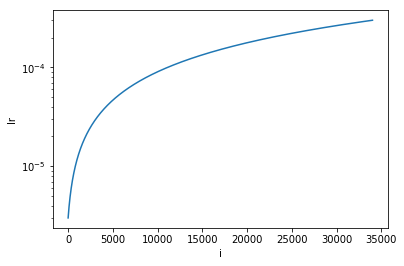

In [25]:
lrf.lr_graph()

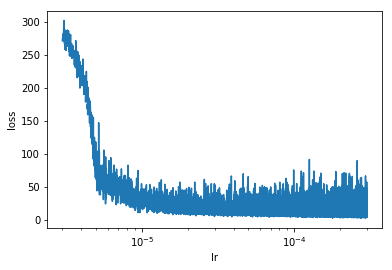

In [26]:
lrf.loss_graph()

In [27]:
schedule = SGDRScheduler(min_lr=3e-5,
                         max_lr=8e-4,
                         steps_per_epoch=STEP_SIZE_TRAIN,
                         lr_decay=0.9,
                         cycle_length=2,
                         mult_factor=1.5)

In [28]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=1000,
                    verbose=1,
                    callbacks=[checkpoint, schedule],
                    shuffle=True)

Epoch 1/1000
 9644/17000 [================>.............] - ETA: 44:27 - loss: 14.8999 - mIoU: 0.8389

KeyboardInterrupt: 

In [ ]:
model.save('inceptionresnetv2_l1loss.h5')

In [ ]:
model.load_weights(chkpt_dir)

In [ ]:
for i in range(0, 2000, 100):
    pred = model.predict(np.expand_dims(x_val[i], axis=0))
    a1 = int(pred[0][0]/rx)
    a2 = int(pred[0][1]/rx)
    b1 = int(pred[0][2]/ry)
    b2 = int(pred[0][3]/ry)
    test_img = x_val[i]
    print(test_img.shape)
    plt.figure(i)
    cv2.rectangle(test_img,(a1,b1),(a2,b2),(0,255,0),3)
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

In [ ]:
test_img = x_val[7]
test_img = np.expand_dims(test_img, axis=0)
pred = model.predict(test_img)
print(pred.shape)
a1 = int(pred[0][0]/rx)
a2 = int(pred[0][1]/rx)
b1 = int(pred[0][2]/ry)
b2 = int(pred[0][3]/ry)
test_img = test_img[0]
cv2.rectangle(test_img,(a1,b1),(a2,b2),(0,255,0),3)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

In [ ]:
model.save('kuchcha_inception_resnet_v2.h5')

In [ ]:
model.load_weights(chkpt_dir)
LABEL = y_val
PRED = model.predict(x_val)
with tf.Session() as sess:
    val = sess.run(mIoU(LABEL, PRED))
    print(val)

In [ ]:
test_df = pd.read_csv(os.path.join('X:/Flipkart GRID - Object Localization (Medium Complexity Round)/orig_data', 'test.csv'))

In [ ]:
print(type(test_df))

In [ ]:
for i, im in enumerate(test_df.image_name):
    img = cv2.imread(os.path.join('X:/Flipkart GRID - Object Localization (Medium Complexity Round)/orig_data/train', im))